<a href="https://colab.research.google.com/github/LiHuaqing-tum/Safe-Flow-Matching/blob/main/final%20correct%20vision(without%20phi%20function).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


def generate_trajectory_pairs(n_samples=500, steps=50):
    input_trajs = []
    target_trajs = []
    for _ in range(n_samples):
        traj = np.zeros((steps, 2))
        traj[0] = np.random.rand(2) * 0.1
        for t in range(1, steps):
            traj[t] = traj[t - 1] + 0.1 * np.random.randn(2)
        input_trajs.append(traj)

        start = traj[0]
        end = np.array([0.9, 0.9]) + 0.05 * np.random.randn(2)
        t_lin = np.linspace(0, 1, steps).reshape(-1, 1)
        base = start + (end - start) * t_lin
        curve = (
            0.05 * np.sin(2 * np.pi * t_lin + np.random.rand() * 2 * np.pi) +
            0.02 * np.sin(6 * np.pi * t_lin + np.random.rand() * 2 * np.pi)
        )
        if np.random.rand() > 0.5:
            base[:, 0] += curve[:, 0]
        else:
            base[:, 1] += curve[:, 0]
        target_trajs.append(base)

    return np.array(input_trajs), np.array(target_trajs)


class TrajectoryPairDataset(Dataset):
    def __init__(self, input_trajs, target_trajs):
        self.input_trajs = torch.tensor(input_trajs, dtype=torch.float32)
        self.target_trajs = torch.tensor(target_trajs, dtype=torch.float32)

    def __len__(self):
        return len(self.input_trajs)

    def __getitem__(self, idx):
        return self.input_trajs[idx], self.target_trajs[idx]


class TimeConditionedVectorField(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 2)
        )

    def forward(self, x, t):

        B, S, _ = x.shape
        if isinstance(t, float) or len(t.shape) == 0:
            t = torch.full((B, S, 1), t, device=x.device)
        elif len(t.shape) == 1:
            t = t[:, None, None].repeat(1, S, 1)
        xt = torch.cat([x, t], dim=-1)  # [B, S, 3]
        return self.net(xt)  # [B, S, 2]


def integrate_trajectory(x0, model, steps=20):
    dt = 1.0 / steps
    x = x0
    for i in range(steps):
        t = i / steps
        v = model(x, t)
        x = x + dt * v
    return x


def train_vector_field(model, dataset, n_epochs=50, batch_size=64, lr=1e-3, steps=20):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0.0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            y_pred = integrate_trajectory(x, model, steps=steps)
            loss = F.mse_loss(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(loader):.6f}")





In [7]:

def visualize_trajectory_evolution(model, x_data, y_data, steps=20, num_samples=5):
    model.eval()
    device = next(model.parameters()).device
    x_data = torch.tensor(x_data[:num_samples], dtype=torch.float32).to(device)
    y_data = y_data[:num_samples]

    trajs_over_time = [x_data.detach().cpu().numpy()]
    x = x_data.clone()
    for i in range(steps):
        t = i / steps
        v = model(x, t)
        x = x + (1.0 / steps) * v
        trajs_over_time.append(x.detach().cpu().numpy())

    # Plot evolution
    for i in range(num_samples):
        plt.figure(figsize=(6, 6))
        for step, traj in enumerate(trajs_over_time):
            alpha = 0.2 + 0.8 * step / steps
            plt.plot(traj[i, :, 0], traj[i, :, 1], color='r', alpha=alpha)
        plt.plot(trajs_over_time[-1][i, :, 0], trajs_over_time[-1][i, :, 1], 'b-', label='Final Predicted')
        plt.plot(y_data[i, :, 0], y_data[i, :, 1], 'g--', label='Target')
        plt.title(f"Sample #{i+1} Trajectory Evolution")
        plt.legend()
        plt.axis("equal")
        plt.grid(True)
        plt.show()




In [6]:

steps = 50
input_trajs, target_trajs = generate_trajectory_pairs(n_samples=500, steps=steps)
dataset = TrajectoryPairDataset(input_trajs, target_trajs)

model = TimeConditionedVectorField(hidden=128)
train_vector_field(model, dataset, n_epochs=2000, steps=20)



Epoch 1: Loss = 0.344341
Epoch 2: Loss = 0.183688
Epoch 3: Loss = 0.118368
Epoch 4: Loss = 0.087508
Epoch 5: Loss = 0.074361
Epoch 6: Loss = 0.068348
Epoch 7: Loss = 0.065692
Epoch 8: Loss = 0.064391
Epoch 9: Loss = 0.063596
Epoch 10: Loss = 0.062978
Epoch 11: Loss = 0.062473
Epoch 12: Loss = 0.062051
Epoch 13: Loss = 0.061532
Epoch 14: Loss = 0.060933
Epoch 15: Loss = 0.060423
Epoch 16: Loss = 0.059890
Epoch 17: Loss = 0.059228
Epoch 18: Loss = 0.058784
Epoch 19: Loss = 0.058144
Epoch 20: Loss = 0.057549
Epoch 21: Loss = 0.057177
Epoch 22: Loss = 0.056672
Epoch 23: Loss = 0.056206
Epoch 24: Loss = 0.055735
Epoch 25: Loss = 0.055297
Epoch 26: Loss = 0.055366
Epoch 27: Loss = 0.055039
Epoch 28: Loss = 0.054411
Epoch 29: Loss = 0.054019
Epoch 30: Loss = 0.053921
Epoch 31: Loss = 0.053487
Epoch 32: Loss = 0.053074
Epoch 33: Loss = 0.052755
Epoch 34: Loss = 0.052792
Epoch 35: Loss = 0.052579
Epoch 36: Loss = 0.052481
Epoch 37: Loss = 0.052057
Epoch 38: Loss = 0.051682
Epoch 39: Loss = 0.05

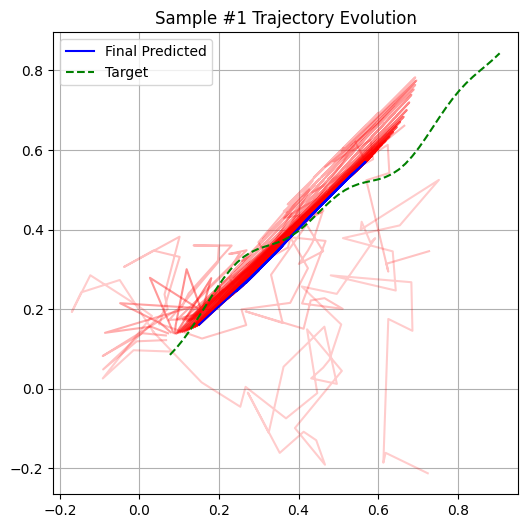

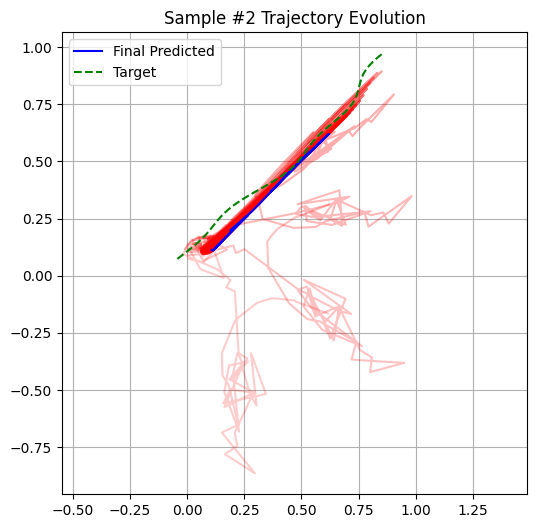

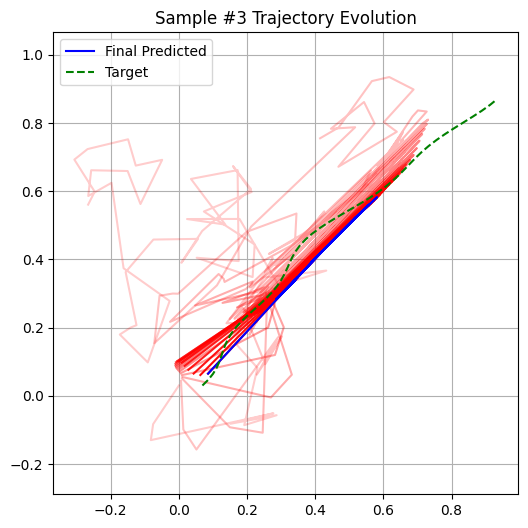

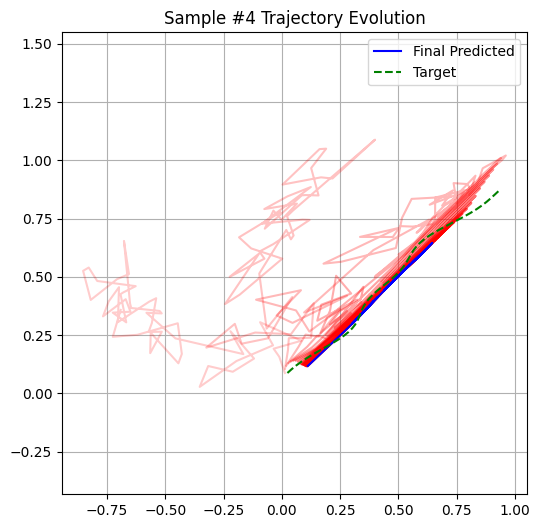

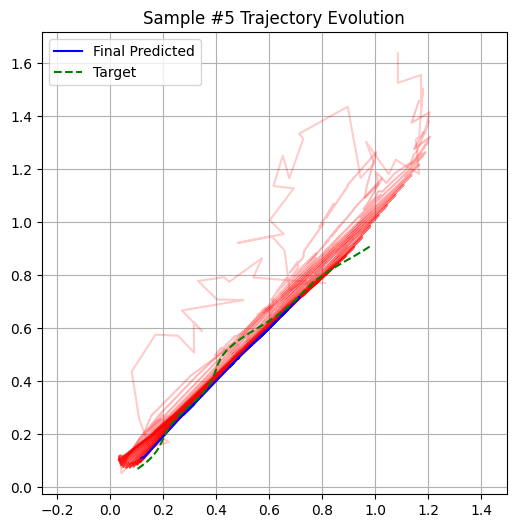

In [8]:

visualize_trajectory_evolution(model, input_trajs, target_trajs, steps=20, num_samples=5)